## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [4]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
print(cv2.__version__)

4.11.0


## Загружаем исходные данные

In [18]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [19]:
# посмотрим на размерность
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [44]:
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train_X[:, 1:], (train_X.shape[0], 28, 28)).astype('float64')
test_img = np.resize(test_X, (test_X.shape[0], 28, 28)).astype('float64')

In [45]:
train_img.shape

(60000, 28, 28)

## Визуализируем исходные данные

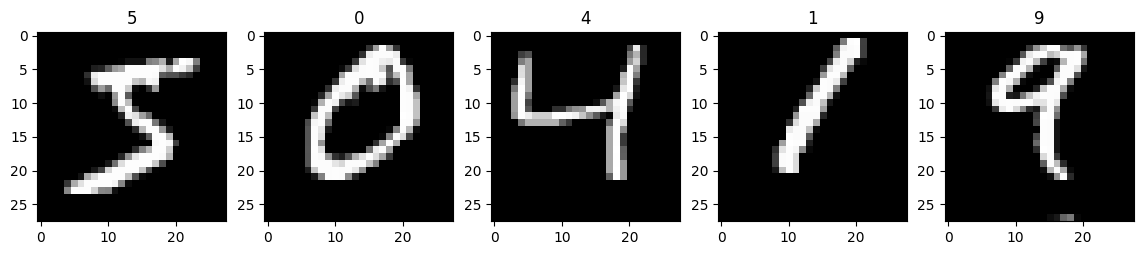

In [46]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_y[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [47]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [48]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [49]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [50]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

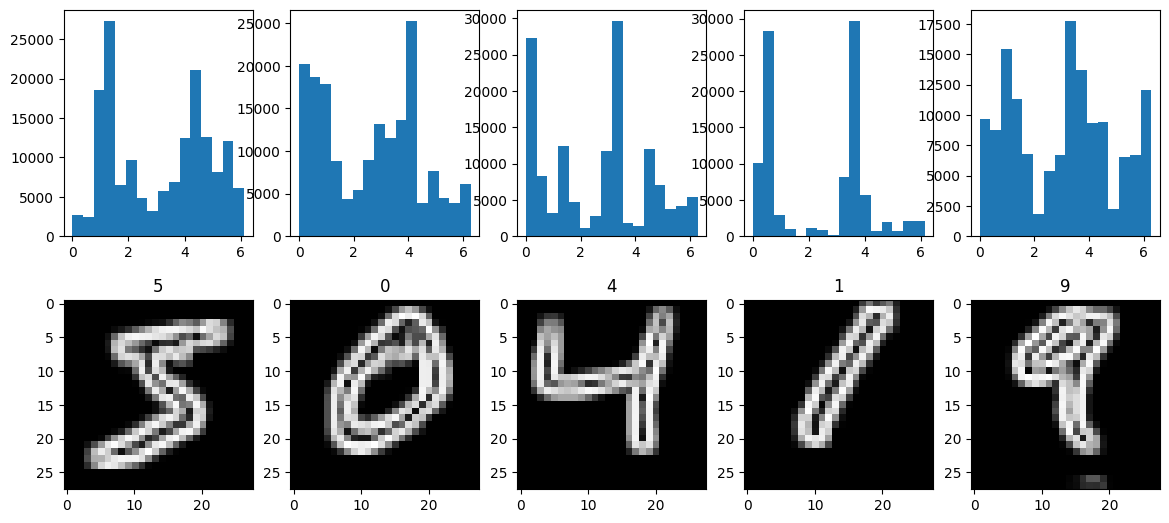

In [51]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_y[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [52]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [53]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [54]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [55]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [57]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_y, train_hist, test_size=0.2,
    random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [58]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [59]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [60]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [61]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.09983333333333333


In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           0       0.12      0.06      0.08      1175
           1       0.12      0.17      0.14      1322
           2       0.09      0.06      0.07      1174
           3       0.11      0.05      0.07      1219
           4       0.10      0.25      0.14      1176
           5       0.09      0.13      0.11      1104
           6       0.09      0.08      0.09      1177
           7       0.10      0.14      0.12      1299
           8       0.13      0.01      0.01      1160
           9       0.10      0.04      0.05      1194

    accuracy                           0.10     12000
   macro avg       0.10      0.10      0.09     12000
weighted avg       0.10      0.10      0.09     12000



In [63]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[ 67 207  73  55 311 145 112 153   4  48]
 [ 50 229  94  78 312 188 108 206   6  51]
 [ 45 170  66  56 326 150 117 199   5  40]
 [ 67 198  83  63 281 200 106 171   5  45]
 [ 60 184  79  57 292 156 117 185   7  39]
 [ 41 204  72  47 281 147  79 186   3  44]
 [ 74 161  61  57 304 164  97 205   4  50]
 [ 48 221  71  80 339 175 130 185   9  41]
 [ 53 203  80  57 294 151 101 168   7  46]
 [ 49 199  83  46 309 161 106 193   3  45]]


## Предсказания на тестовыйх данных

In [64]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

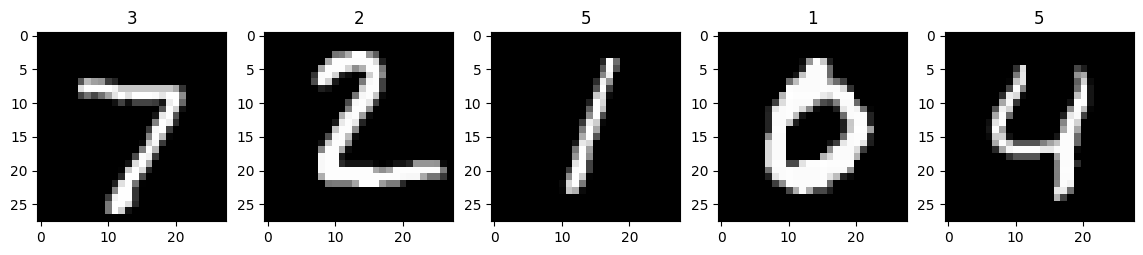

In [65]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [66]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [67]:
!head submit.txt

ImageId,Label
1,3
2,2
3,5
4,1
5,5
6,5
7,7
8,6
9,2


In [ ]:
# Your submission scored 0.41700